## Practical 3b - Using Spark SQL for Data Preparation (Solution)
In this exercise, we shall do some more practice on data exploration. We shall use the dataset `profratings.csv` which contains information about instructors and courses. Instructor attributes include age, beauty score, minority status, gender, native competency in English, tenure status, and a variable uniquely identifying each professor. Course-related attributes include teaching evaluation score, course credits, course division, number of students completing the teaching evaluation survey, and the number of students enrolled in the course. The specific details of the fields (each separated by a comma) are as follows:

Feature   | Description  
-------   | ------------
 beauty   | Rating of the instructor's physical appearance by a panel of six students, averaged across six panelists,      transformed to have a mean of zero. 
 eval     | Course overall teaching evaluation score, on a scale of 1 (very unsatisfactory) to 5 (excellent).
 minority | Categorical. Indicates whether the instructor belong to a minority i.e. non-Caucasian (yes/no).
 age      | The professor's age. 
 gender   | Categorical. Indicates the instructor's gender (male/female). 
 native   | Categorical. Indicates whether the instructor is a native English speaker (yes/no).
 tenure   | Categorical. Indicates whether the instructor is on tenure track (yes/no). 
 credits  | Categorical. Indicates whether the course is a single-credit elective for example, yoga, aerobics, dance (single/more). 
 division | Categorical. Indicates whether the course is an upper or lower division course. Lower division courses are mainly for large freshman and sophomore courses (lower/upper). 
 students | Number of students who participated in the evaluation. 
 allstudents | Number of students enrolled in the course. 
 prof     | The instructor's identifier. 

Let us start by loading the dataset:
```python
profDF = spark.read.csv("/home/training/data/profratings.csv", inferSchema=True, header=True)
```

In [1]:
profDF = spark.read.csv("/home/training/data/profratings.csv", inferSchema=True, header=True)

### Descriptive Statistics
Count the frequencies of all the categorical features. Check whether there is any imbalanced in any of these features. Expected output:
```
+--------+-----+
|minority|count|
+--------+-----+
|      no|  399|
|     yes|   64|
+--------+-----+

+------+-----+
|gender|count|
+------+-----+
|female|  195|
|  male|  268|
+------+-----+

+-------+-----+
|credits|count|
+-------+-----+
|   more|  436|
| single|   27|
+-------+-----+

+--------+-----+
|division|count|
+--------+-----+
|   upper|  306|
|   lower|  157|
+--------+-----+

+------+-----+
|native|count|
+------+-----+
|    no|   28|
|   yes|  435|
+------+-----+

+------+-----+
|tenure|count|
+------+-----+
|    no|  102|
|   yes|  361|
+------+-----+
```

In [2]:
cat_features = ["minority", "gender", "native", "tenure", "credits", "division"]

results = [profDF.groupby(feature).count() for feature in profDF.columns if feature in cat_features]
for result in results:
    result.show()

+--------+-----+
|minority|count|
+--------+-----+
|      no|  399|
|     yes|   64|
+--------+-----+

+------+-----+
|gender|count|
+------+-----+
|female|  195|
|  male|  268|
+------+-----+

+-------+-----+
|credits|count|
+-------+-----+
|   more|  436|
| single|   27|
+-------+-----+

+--------+-----+
|division|count|
+--------+-----+
|   upper|  306|
|   lower|  157|
+--------+-----+

+------+-----+
|native|count|
+------+-----+
|    no|   28|
|   yes|  435|
+------+-----+

+------+-----+
|tenure|count|
+------+-----+
|    no|  102|
|   yes|  361|
+------+-----+



For the numerical features, use the `describe` method to gather information about them. Expected output:
```
+-------+------------------+--------------------+------------------+-----------------+------------------+
|summary|               age|              beauty|              eval|         students|       allstudents|
+-------+------------------+--------------------+------------------+-----------------+------------------+
|  count|               463|                 463|               463|              463|               463|
|   mean|48.365010799136066|6.263498922016964E-8|3.9982721382289412|36.62419006479482|55.177105831533474|
| stddev| 9.802742037864816|   0.788647667327804|0.5548655656195948|45.01848127156701| 75.07279983847909|
|    min|                29|           -1.450494|               2.1|                5|                 8|
|    max|                73|            1.970023|               5.0|              380|               581|
+-------+------------------+--------------------+------------------+-----------------+------------------+
```

In [3]:
numerical = ['age', 'beauty', 'eval', "students", "allstudents"]
desc = profDF.describe(numerical)
desc.show()

+-------+------------------+--------------------+------------------+-----------------+------------------+
|summary|               age|              beauty|              eval|         students|       allstudents|
+-------+------------------+--------------------+------------------+-----------------+------------------+
|  count|               463|                 463|               463|              463|               463|
|   mean|48.365010799136066|6.263498922016964E-8|3.9982721382289412|36.62419006479482|55.177105831533474|
| stddev| 9.802742037864816|   0.788647667327804|0.5548655656195948|45.01848127156701| 75.07279983847909|
|    min|                29|           -1.450494|               2.1|                5|                 8|
|    max|                73|            1.970023|               5.0|              380|               581|
+-------+------------------+--------------------+------------------+-----------------+------------------+



Let us find the skewness of all the numerical features. Expected output:
```
+------------------+-------------------+-------------------+------------------+---------------------+
|skewness(students)|      skewness(age)|     skewness(eval)|  skewness(beauty)|skewness(allstudents)|
+------------------+-------------------+-------------------+------------------+---------------------+
|4.4801651397149875|0.04851377200671605|-0.4658752817614782|0.5141316935433676|    4.142286232882466|
+------------------+-------------------+-------------------+------------------+---------------------+
```

In [4]:
dict = {}
for feature in numerical:
    dict[feature] = 'skewness'
    
profDF.agg(dict).show()

+------------------+-------------------+-------------------+------------------+---------------------+
|skewness(students)|      skewness(age)|     skewness(eval)|  skewness(beauty)|skewness(allstudents)|
+------------------+-------------------+-------------------+------------------+---------------------+
|4.4801651397149875|0.04851377200671605|-0.4658752817614782|0.5141316935433676|    4.142286232882466|
+------------------+-------------------+-------------------+------------------+---------------------+



### Correlations
Create a correlations matrix using the numerical features. Expected output:
```
╒═════════════╤═══════╤═══════════╤════════════╤════════════╤═══════════════╕
│             │  age  │  beauty   │    eval    │  students  │  allstudents  │
╞═════════════╪═══════╪═══════════╪════════════╪════════════╪═══════════════╡
│ age         │   1   │ -0.297893 │ -0.0516962 │ -0.0304611 │  -0.0126265   │
├─────────────┼───────┼───────────┼────────────┼────────────┼───────────────┤
│ beauty      │       │     1     │  0.189039  │  0.13065   │   0.0996019   │
├─────────────┼───────┼───────────┼────────────┼────────────┼───────────────┤
│ eval        │       │           │     1      │ 0.0354667  │  -0.00122934  │
├─────────────┼───────┼───────────┼────────────┼────────────┼───────────────┤
│ students    │       │           │            │     1      │   0.972056    │
├─────────────┼───────┼───────────┼────────────┼────────────┼───────────────┤
│ allstudents │       │           │            │            │       1       │
╘═════════════╧═══════╧═══════════╧════════════╧════════════╧═══════════════╛
```

In [5]:
n_numerical = len(numerical)
corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    for j in range(i, n_numerical):
        temp.append(profDF.corr(numerical[i], numerical[j]))
    corr.append(temp)

from tabulate import tabulate
print(tabulate(corr, headers=numerical, showindex=numerical, tablefmt="fancy_grid", numalign="center"))

╒═════════════╤═══════╤═══════════╤════════════╤════════════╤═══════════════╕
│             │  age  │  beauty   │    eval    │  students  │  allstudents  │
╞═════════════╪═══════╪═══════════╪════════════╪════════════╪═══════════════╡
│ age         │   1   │ -0.297893 │ -0.0516962 │ -0.0304611 │  -0.0126265   │
├─────────────┼───────┼───────────┼────────────┼────────────┼───────────────┤
│ beauty      │       │     1     │  0.189039  │  0.13065   │   0.0996019   │
├─────────────┼───────┼───────────┼────────────┼────────────┼───────────────┤
│ eval        │       │           │     1      │ 0.0354667  │  -0.00122934  │
├─────────────┼───────┼───────────┼────────────┼────────────┼───────────────┤
│ students    │       │           │            │     1      │   0.972056    │
├─────────────┼───────┼───────────┼────────────┼────────────┼───────────────┤
│ allstudents │       │           │            │            │       1       │
╘═════════════╧═══════╧═══════════╧════════════╧════════════╧═══

### Visualization
Finally, create a histogram of the evaluation scores.

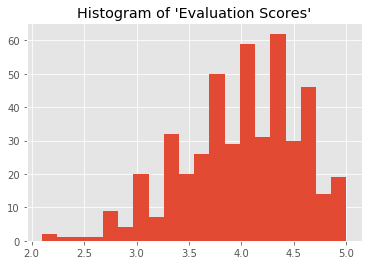

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

eval_list = [i[0] for i in profDF.select("eval").collect()]
plt.title("Histogram of 'Evaluation Scores'")
plt.hist(eval_list, bins = 20)
plt.show()